In [9]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from dask.distributed import Client, progress

In [10]:
home = Path('/Users/jonniebarnsley/Downloads/A0_multiplier')

runs = ['n2E30', 'n2E50', 'n4E30', 'n4E50']
vels = {}
for run in runs:
    xfile = xr.open_dataset(home / 'xVel' / f'A0_multiplier_{run}_xVel_0lev.nc')
    yfile = xr.open_dataset(home / 'yVel' / f'A0_multiplier_{run}_yVel_0lev.nc')
    u = xfile.xVel
    v = yfile.yVel
    speed = (u**2 + v**2)**0.5
    speed.name = 'speed'
    vels[run] = speed

In [25]:
midx = xr.open_dataset('/Users/jonniebarnsley/Downloads/axial_inversions/xVel/lasagne_run01_xVel_0lev.nc')
midy = xr.open_dataset('/Users/jonniebarnsley/Downloads/axial_inversions/yVel/lasagne_run01_yVel_0lev.nc')
mid_speed = (midx.xVel**2 + midy.yVel**2)**0.5
vels['mid'] = mid_speed

In [50]:
obs = xr.open_dataset('/Users/jonniebarnsley/data/MEaSUREs/MEaSUREs_antarctica_ice_velocity_v2_8km.nc')
renamed = obs.rename({'x': 'y', 'y': 'x'})
speed_obs = (renamed.VX**2 + renamed.VY**2)**0.5

diffs = {}
for run, vel in vels.items():
    diffs[run] = vel - speed_obs

misfits = {}
for run, diff in diffs.items():
    misfits[run] = (diff**2).sum(dim=['x', 'y'])

Text(0, 0.5, '$|u-u_{obs}|^2_2$')

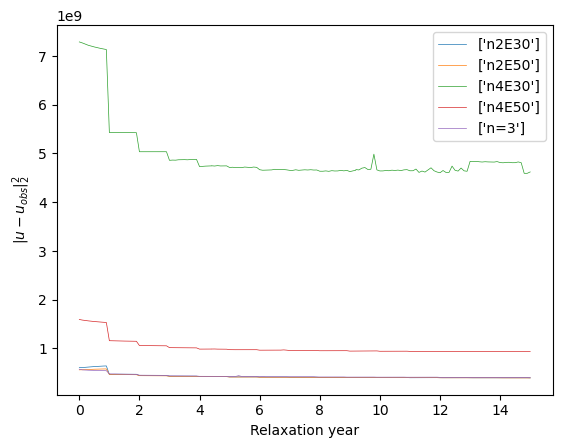

In [66]:
for run, misfit in misfits.items():
    plt.plot(misfit.time, misfit.values, label=[run if run != 'mid' else 'n=3'], lw=0.5)
plt.legend()
#plt.ylim(3e8, 7e8)
plt.xlabel('Relaxation year')
plt.ylabel('$|u-u_{obs}|^2_2$')

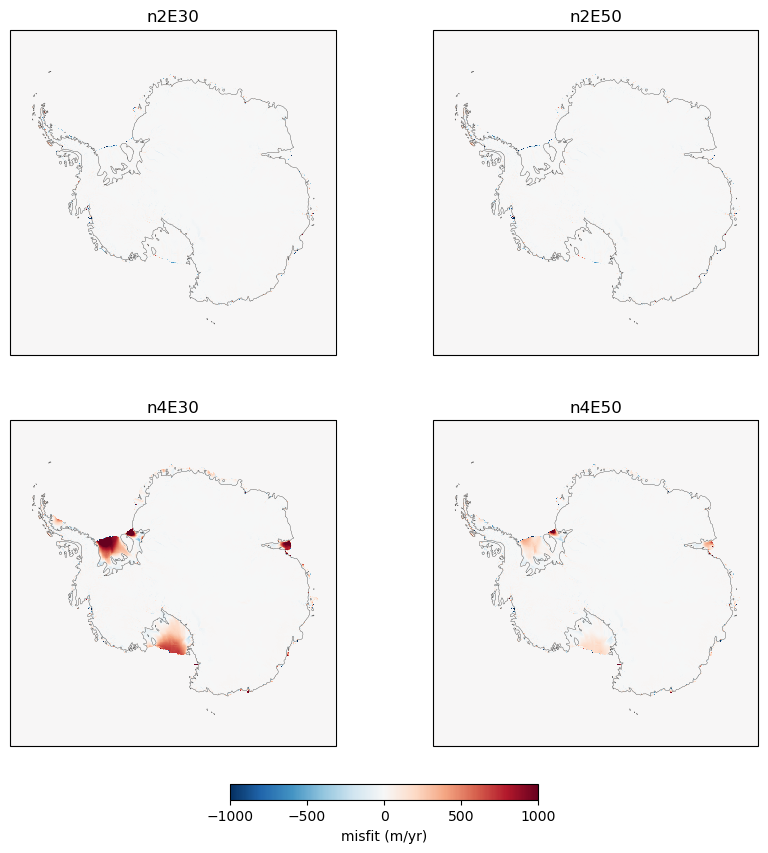

In [61]:
import cartopy.crs as ccrs
from local.lib.myplots import spatial
fig, axes = plt.subplots(2, 2, figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})
for ax, (run, diff) in zip(axes.flat, diffs.items()):
    final_diff = diff.isel(time=-1)
    im = spatial(ax, final_diff, cmap='RdBu_r', vmin=-1000, vmax=1000)
    ax.set_title(run)

fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', label='misfit (m/yr)', fraction=0.02, pad=0.05)

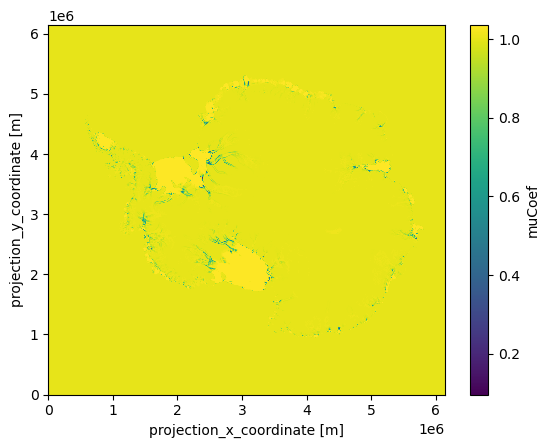

In [54]:
last_n4E30_iter = xr.open_dataset('/Users/jonniebarnsley/Downloads/ctrl.lasagne_n4E30_0lev.nc')
last_n4E30_iter.muCoef.plot()